##  Reproducing Genetic Alogrithm Generated CNC Cutting Parameters with a Neural Network

### Introducton

This notebook aims to reproduce the output data of *Multi-Objective Optimization of Turning Process during Machining of AlMg1SiCu (Aluminum) Using Non-Dominated Sorted Genetic Algorithm* by Rahul Dhabalea, VijayKumar S. Jattib, and T.P.Singhc. The study used a genetic algorithm (GA) to generate novel cutting parameters, and predict material removal rate & surface roughness. The study can be found [here](https://www.sciencedirect.com/science/article/pii/S2211812814005318) for further reading but some explanation will follow, mainly concerning the differences between goals and the methodology used in creating the artificial neural network (ANN).

### Background

The GA used twenty seven rows of input data that are a series of test cuts where a CNC machine tool was set to turn a constant diameter with a range of spindle speeds (rpm), feed rates (mm/rev), and depths of cut(mm). The results of each test cut take the form of a calculated material remove rate (mm$^3$/min) and surface roughness (μm) measurement. Their goal was to have the GA produce cutting conditions and results which maximized material removal rate and minimized surface roughness. These two outcomes are conflicting in nature and so result in one ideal output for each scenario. In total the GA generated and ranked sixteen suggestions. Five of the sixteen results were chosen for validation of the GA results and tested on the CNC mahcine. The results had an average of less than five percent error from the forcast. 

### This Notebook

The major difference between the study and this notebook, besides the algorithm used, is in the prediction method. The ANN will be designed to accept a desired material removal rate and surface roughness as inputs, and generate the spindle speed, feed rate, and depth of cut as outputs. The initial twenty seven rows will be used as training data, while the five rows used for validation in the study will be split into four rows of testing data and one row for validation. The single row kept for validation will have the lowest surface roughness value in the entire dataset. This makes for a more realistic test of the ANN because an end user would be requesting results that are better than the initial dataset and this input data will be outside anything the ANN has been trained on which makes for a more difficult prediction. 

### Details

Usually a dataset's features very widely between magnitude, units, and range. For this reason it's important to scale the data because most machine learning models recognize patterns using Eucledian distance between any two points. There are many ways to scale data but in this notebook two of the more common methods in the Scikit-Learn library will be applied separetly. Both scaled data sets will then be used with Talos to tune the hyperparameters of the neural network and the best results of each will be applied to the Keras model for final results on the validation data.


### Conclusion

This notebook was made to show the feasability in using a neaural network made with common open source tools to facilitate process improvements in manufacturing by replicating the successful results of a GA and adjusting the input and output parameters to create a tool useful for the shop floor.

Test cuts of this nature will likely produce a very samll amounts of data as seen in the study. Generally in machine learning a large amount of data is required for a robust model to be created, but it appears an acceptable level of accuracy is achievable with a limited dataset.

Other cutting or result data would likely need to be used to fit a real business model, for instance replacing material removal rate with some measure of process stability like tool life or "time since adjustment", but due to the proprietary nature of manufacturing the available data to develop tests with is limited.

In [168]:
# import dependencies

%matplotlib inline
import keras
from keras.models import Sequential
from keras.activations import *
from keras.layers import *
from keras.losses import *
from keras.optimizers import *
from keras.layers import advanced_activations
import matplotlib.pyplot as plt
import pandas as pd
import seaborn
import seaborn as sns
import sklearn
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import talos as ta
import warnings
warnings.filterwarnings("ignore")

# establish fixed seeding for reproducability
seed_value= 0
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import tensorflow as tf
tf.set_random_seed(seed_value)
from keras import backend as K
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

# suppress NumPy arrays scientific notation and round decimals to three places
np.set_printoptions(suppress=True)
np.printoptions(precision=3, suppress=True)

# print the version of each library being used
print('Dependency Version:\n')
print('Keras', keras.__version__)
print('Numpy', np.__version__)
print('Pandas', pd.__version__)
print('Seaborn', seaborn.__version__)
print('Sklearn', sklearn.__version__)
print('Talos', ta.__version__)

Dependency Version:

Keras 2.2.4
Numpy 1.15.0
Pandas 0.25.0
Seaborn 0.9.0
Sklearn 0.20.1
Talos 0.6.3


In [169]:
# import data
data = pd.read_csv('data.txt', delim_whitespace=True, encoding='ISO-8859-1')
# drop the index number of the tests
data.drop(columns=['Sr._No.', 'MRR(mm3/min)'], inplace=True)

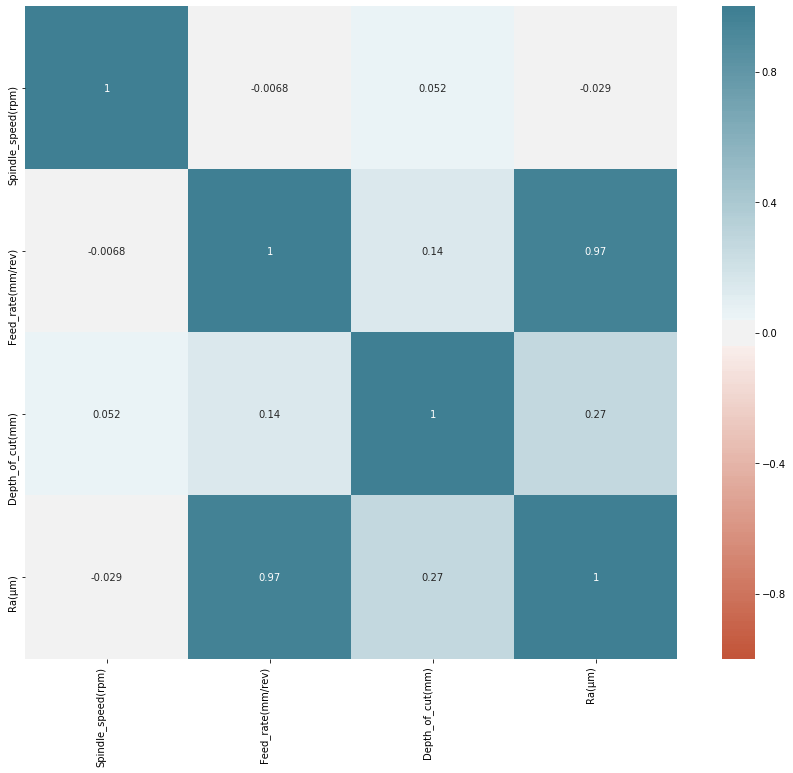

In [170]:
# a look at the overall correlation of each feature in the raw data
heat_data = data
plt.figure(figsize=(16, 12))
corr = heat_data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);
plt.savefig('heatmap')

In [171]:
# change the dataframe into a NumPy array
np_data = data.values

In [172]:
# Transforms features by scaling each feature to a given range, -1 and 1 in this case
MinMax_scaler = MinMaxScaler(feature_range=(-1, 1))
np_data_MinMax = MinMax_scaler.fit_transform(np_data)

In [173]:
# Standardize features by removing the mean and scaling to unit variance
Standard_scaler = StandardScaler()
np_data_Standard = Standard_scaler.fit_transform(np_data)

In [174]:
# split the scaled MinMax data into training, testing, and validation sets
train_features_MinMax = np_data_MinMax[0:27 , 3:4]
test_features_MinMax = np_data_MinMax[28:32, 3:4]
validation_features_MinMax = np_data_MinMax[27, 3:4]
train_labels_MinMax = np_data_MinMax[0:27, 0:3]
test_labels_MinMax = np_data_MinMax[28:32, 0:3]
validation_labels_MinMax = np_data_MinMax[27, 0:3]

# reshape the validation data because it's only one row
validation_features_MinMax = validation_features_MinMax.reshape(1, -1)
validation_labels_MinMax = validation_labels_MinMax.reshape(1, -1)

In [175]:
# split the scaled Standard data into training, testing, and validation sets
train_features_Standard = np_data_Standard[0:27 , 3:4]
test_features_Standard = np_data_Standard[28:32, 3:4]
validation_features_Standard = np_data_Standard[27, 3:4]
train_labels_Standard = np_data_Standard[0:27, 0:3]
test_labels_Standard = np_data_Standard[28:32, 0:3]
validation_labels_Standard = np_data_Standard[27, 0:3]

# reshape the validation data because it's only one row
validation_features_Standard = validation_features_Standard.reshape(1, -1)
validation_labels_Standard = validation_labels_Standard.reshape(1, -1)

In [176]:
# combining original the testing group to compare against rescaled groups below
np_test_data = np.concatenate([np_data[28:32, 0:3], np_data[28:32, 3:4]], axis=1)
np_test_data

array([[1100.  ,    0.05,    0.69,    0.29],
       [1095.  ,    0.15,    1.2 ,    1.87],
       [1097.  ,    0.13,    1.14,    1.54],
       [1094.  ,    0.12,    1.15,    1.45]])

In [177]:
# combine the MinMax testing group and rescale
test_data_MinMax = np.concatenate([test_labels_MinMax, test_features_MinMax], axis=1)
MinMax_scaler.inverse_transform(test_data_MinMax)

array([[1100.  ,    0.05,    0.69,    0.29],
       [1095.  ,    0.15,    1.2 ,    1.87],
       [1097.  ,    0.13,    1.14,    1.54],
       [1094.  ,    0.12,    1.15,    1.45]])

In [178]:
# combine the Standard testing group and rescale
test_data_Standard = np.concatenate([test_labels_Standard, test_features_Standard], axis=1)
Standard_scaler.inverse_transform(test_data_Standard)

array([[1100.  ,    0.05,    0.69,    0.29],
       [1095.  ,    0.15,    1.2 ,    1.87],
       [1097.  ,    0.13,    1.14,    1.54],
       [1094.  ,    0.12,    1.15,    1.45]])

In [179]:
# parameters to try during Talos optimization

p = {
    'first_neuron': [8],
    'second_neuron': [64],
    'third_neuron': [64],
    'fourth_neuron': [56],
    'fifth_neuron': [48],
    'sixth_neuron': [40],
    'seventh_neuron': [32, 40],
    'eighth_neuron': [24],
    'nineth_neuron': [16],
    'tenth_neuron': [8],
    'batch_size': [10, 20, 30],
    'activation': [relu,
                   softsign,
                   elu,
                   linear],
    'optimizer' : ['Adam'],
    'epochs': [100, 1000, 10000],
    'loss' : [mean_absolute_error, poisson] 
}

In [180]:
# create a model for MinMax scaled data to use with Talos
def MinMax_ann(train_features, train_labels, test_features, test_labels, params):
    
    # replace the hyperparameter inputs with references to params dictionary 
    model = Sequential()
    model.add(Dense(params['first_neuron'], input_dim=2, activation=params['activation']))
    model.add(Dense(params['second_neuron'], activation='relu'))
    model.add(Dense(params['third_neuron'], activation='relu'))
    model.add(Dense(params['fourth_neuron'], activation='relu'))
    model.add(Dense(params['fifth_neuron'], activation='relu'))
    model.add(Dense(params['sixth_neuron'], activation='relu'))
    model.add(Dense(params['seventh_neuron'], activation='relu'))
    model.add(Dense(params['eighth_neuron'], activation='relu'))
    model.add(Dense(params['nineth_neuron'], activation='relu'))
    model.add(Dense(params['tenth_neuron'], activation='relu'))
    model.add(Dense(3, activation='linear'))
    model.compile(loss=params['loss'], optimizer=params['optimizer'], metrics=['accuracy'])
    
    # make sure history object is returned by model.fit()
    out = model.fit(train_features_MinMax, train_labels_MinMax,
                    epochs=params['epochs'],
                    batch_size=params['batch_size'],
                    verbose=0,
                    validation_data=[test_features_MinMax, test_labels_MinMax])
    
    # model output
    return out, model

In [181]:
# create a model for Standard scaled data to use with Talos
def Standard_ann(train_features, train_labels, test_features, test_labels, params):
    
    # replace the hyperparameter inputs with references to params dictionary 
    model = Sequential()
    model.add(Dense(params['first_neuron'], input_dim=2, activation=params['activation']))
    model.add(Dense(params['second_neuron'], activation='relu'))
    model.add(Dense(params['third_neuron'], activation='relu'))
    model.add(Dense(params['fourth_neuron'], activation='relu'))
    model.add(Dense(params['fifth_neuron'], activation='relu'))
    model.add(Dense(params['sixth_neuron'], activation='relu'))
    model.add(Dense(params['seventh_neuron'], activation='relu'))
    model.add(Dense(params['eighth_neuron'], activation='relu'))
    model.add(Dense(params['nineth_neuron'], activation='relu'))
    model.add(Dense(params['tenth_neuron'], activation='relu'))
    model.add(Dense(3, activation='linear'))
    model.compile(loss=params['loss'], optimizer=params['optimizer'], metrics=['accuracy'])
    
    # make sure history object is returned by model.fit()
    out = model.fit(train_features_Standard, train_labels_Standard,
                    epochs=params['epochs'],
                    batch_size=params['batch_size'],
                    verbose=0,
                    validation_data=[test_features_Standard, test_labels_Standard])
    
    # model output
    return out, model

In [182]:
# combine MinMax training and test features, and training and test labels for Talos experiment
features_MinMax = np.concatenate((train_features_MinMax, test_features_MinMax), axis=0)
labels_MinMax = np.concatenate((train_labels_MinMax, test_labels_MinMax), axis=0)

In [183]:
# combine Standard training and test features, and training and test labels for Talos experiment
features_Standard = np.concatenate((train_features_Standard, test_features_Standard), axis=0)
labels_Standard = np.concatenate((train_labels_Standard, test_labels_Standard), axis=0)

https://rdrr.io/cran/kerasR/man/Initalizers.html

# run the Talos experiment on MinMax data and model
MinMax_t = ta.Scan(features_MinMax, labels_MinMax, 
            params=p, 
            model=MinMax_ann,
            experiment_name='MinMax',
            )

# run the Talos experiment on Standard data and model
Standard_t = ta.Scan(features_Standard, labels_Standard, 
            params=p, 
            model=Standard_ann,
            experiment_name='Standard'
            )

In [184]:
# load the results data
MinMax_reporting = pd.read_csv('MinMax\\082519080201.csv')
Standard_reporting = pd.read_csv('Standard\\082519092035.csv')

In [185]:
# sort by validation loss and accuracy and show to best result
MinMax_reporting.sort_values(['val_loss', 'val_acc'], ascending=[True, False], inplace=True)
MinMax_reporting.head(1)

,round_epochs,val_loss,val_acc,loss,acc,activation,batch_size,eighth_neuron,epochs,fifth_neuron,first_neuron,fourth_neuron,loss.1,nineth_neuron,optimizer,second_neuron,seventh_neuron,sixth_neuron,tenth_neuron,third_neuron
124,1000,0.181324,0.5,0.25004,0.703704,<function linear at 0x00000000100513A8>,20,24,1000,48,8,56,<function mean_absolute_error at 0x00000000100...,16,Adam,64,32,40,8,64


In [186]:
# sort by validation loss and accuracy and show the best result
Standard_reporting.sort_values(['val_loss', 'val_acc'], ascending=[True, False], inplace=True)
Standard_reporting.head(1)

,round_epochs,val_loss,val_acc,loss,acc,activation,batch_size,eighth_neuron,epochs,fifth_neuron,first_neuron,fourth_neuron,loss.1,nineth_neuron,optimizer,second_neuron,seventh_neuron,sixth_neuron,tenth_neuron,third_neuron
57,10000,0.180523,1.0,0.036529,1.0,<function softsign at 0x0000000010051048>,20,24,10000,48,8,56,<function mean_absolute_error at 0x00000000100...,16,Adam,64,40,40,8,64


# Define the MinMax model using the top performing parameters from Talos
MinMax_model = Sequential()
MinMax_model.add(Dense(8, input_dim=1, activation='relu'))
MinMax_model.add(Dense(64, activation='relu'))
MinMax_model.add(Dense(64, activation='relu'))
MinMax_model.add(Dense(56, activation='relu'))
MinMax_model.add(Dense(48, activation='relu'))
MinMax_model.add(Dense(40, activation='relu'))
MinMax_model.add(Dense(32, activation='relu'))
MinMax_model.add(Dense(24, activation='relu'))
MinMax_model.add(Dense(16, activation='relu'))
MinMax_model.add(Dense(8, activation='relu'))
MinMax_model.add(Dense(3, activation='relu'))
MinMax_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

MinMax_model.fit(train_features_MinMax,
                 train_labels_MinMax,
                 validation_data=(test_features_MinMax, test_labels_MinMax),
                 batch_size=20,
                 epochs=1000)

weights_list = MinMax_model.get_weights()
weights_list

# THIS IS THE BEST SO FAR, DO NOT DELETE!

# Define the Standard model using the top performing parameters from Talos
Standard_model = Sequential()
Standard_model.add(Dense(8, input_dim=2, activation='relu'))
Standard_model.add(Dense(64, activation='relu'))
Standard_model.add(Dense(64, activation='relu'))
Standard_model.add(Dense(56, activation='relu'))
Standard_model.add(Dense(48, activation='relu'))
Standard_model.add(Dense(40, activation='relu'))
Standard_model.add(Dense(32, activation='relu'))
Standard_model.add(Dense(24, activation='relu'))
Standard_model.add(Dense(16, activation='relu'))
Standard_model.add(Dense(8, activation='relu'))
Standard_model.add(Dense(3, activation='linear'))
Standard_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['accuracy'])

Standard_model.fit(train_features_Standard,
                 train_labels_Standard,
                 validation_data=(test_features_Standard, test_labels_Standard),
                 batch_size=20,
                 epochs=1000)

In [187]:
# Define the Standard model using the top performing parameters from Talos
Standard_model = Sequential()
Standard_model.add(Dense(8, input_dim=1, activation='relu'))
Standard_model.add(Dense(64, activation='relu'))
Standard_model.add(Dense(64, activation='relu'))
Standard_model.add(Dense(56, activation='relu'))
Standard_model.add(Dense(48, activation='relu'))
Standard_model.add(Dense(40, activation='relu'))
Standard_model.add(Dense(32, activation='relu'))
Standard_model.add(Dense(24, activation='relu'))
Standard_model.add(Dense(16, activation='relu'))
Standard_model.add(Dense(8, activation='relu'))
Standard_model.add(Dense(3, activation='linear'))
Standard_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['accuracy'])

Standard_model.fit(train_features_Standard,
                 train_labels_Standard,
                 validation_data=(test_features_Standard, test_labels_Standard),
                 batch_size=20,
                 epochs=1000)

Train on 27 samples, validate on 4 samples
Epoch 1/1000
27/27 [==============================] - 4s 164ms/step - loss: 0.8368 - acc: 0.4074 - val_loss: 0.9119 - val_acc: 0.2500
Epoch 2/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.8351 - acc: 0.5185 - val_loss: 0.9120 - val_acc: 0.2500
Epoch 3/1000
27/27 [==============================] - 0s 2ms/step - loss: 0.8332 - acc: 0.5185 - val_loss: 0.9117 - val_acc: 0.2500
Epoch 4/1000
27/27 [==============================] - 0s 2ms/step - loss: 0.8316 - acc: 0.5185 - val_loss: 0.9118 - val_acc: 0.2500
Epoch 5/1000
27/27 [==============================] - 0s 2ms/step - loss: 0.8295 - acc: 0.5185 - val_loss: 0.9122 - val_acc: 0.2500
Epoch 6/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.8273 - acc: 0.5185 - val_loss: 0.9121 - val_acc: 0.2500
Epoch 7/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.8246 - acc: 0.5185 - val_loss: 0.9122 - val_acc: 0.2500
Epoch 8/1000
27/27 [===========

27/27 [==============================] - 0s 1ms/step - loss: 0.5978 - acc: 0.7407 - val_loss: 0.7381 - val_acc: 0.5000
Epoch 63/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5937 - acc: 0.7407 - val_loss: 0.7340 - val_acc: 0.5000
Epoch 64/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5964 - acc: 0.6667 - val_loss: 0.7360 - val_acc: 0.5000
Epoch 65/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5943 - acc: 0.5926 - val_loss: 0.7541 - val_acc: 0.2500
Epoch 66/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5859 - acc: 0.6667 - val_loss: 0.7600 - val_acc: 0.2500
Epoch 67/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5907 - acc: 0.6667 - val_loss: 0.7238 - val_acc: 0.2500
Epoch 68/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5921 - acc: 0.5926 - val_loss: 0.7182 - val_acc: 0.2500
Epoch 69/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5943 -

27/27 [==============================] - 0s 3ms/step - loss: 0.5672 - acc: 0.6667 - val_loss: 0.7148 - val_acc: 0.2500
Epoch 124/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5665 - acc: 0.6667 - val_loss: 0.7117 - val_acc: 0.2500
Epoch 125/1000
27/27 [==============================] - 0s 926us/step - loss: 0.5661 - acc: 0.6667 - val_loss: 0.7371 - val_acc: 0.2500
Epoch 126/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5679 - acc: 0.6667 - val_loss: 0.7321 - val_acc: 0.2500
Epoch 127/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5675 - acc: 0.6667 - val_loss: 0.7259 - val_acc: 0.2500
Epoch 128/1000
27/27 [==============================] - 0s 833us/step - loss: 0.5646 - acc: 0.6667 - val_loss: 0.7330 - val_acc: 0.2500
Epoch 129/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5657 - acc: 0.6667 - val_loss: 0.7158 - val_acc: 0.2500
Epoch 130/1000
27/27 [==============================] - 0s 1ms/step - los

27/27 [==============================] - 0s 1ms/step - loss: 0.5565 - acc: 0.6667 - val_loss: 0.7380 - val_acc: 0.2500
Epoch 185/1000
27/27 [==============================] - 0s 741us/step - loss: 0.5594 - acc: 0.6667 - val_loss: 0.7167 - val_acc: 0.2500
Epoch 186/1000
27/27 [==============================] - 0s 926us/step - loss: 0.5539 - acc: 0.6667 - val_loss: 0.7224 - val_acc: 0.2500
Epoch 187/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5537 - acc: 0.6667 - val_loss: 0.7324 - val_acc: 0.2500
Epoch 188/1000
27/27 [==============================] - 0s 3ms/step - loss: 0.5572 - acc: 0.6667 - val_loss: 0.7206 - val_acc: 0.2500
Epoch 189/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5560 - acc: 0.6667 - val_loss: 0.7223 - val_acc: 0.2500
Epoch 190/1000
27/27 [==============================] - 0s 926us/step - loss: 0.5566 - acc: 0.6667 - val_loss: 0.7256 - val_acc: 0.2500
Epoch 191/1000
27/27 [==============================] - 0s 1ms/step - l

Epoch 245/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5563 - acc: 0.6667 - val_loss: 0.7140 - val_acc: 0.2500
Epoch 246/1000
27/27 [==============================] - 0s 833us/step - loss: 0.5586 - acc: 0.6667 - val_loss: 0.7382 - val_acc: 0.2500
Epoch 247/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5565 - acc: 0.6667 - val_loss: 0.7518 - val_acc: 0.2500
Epoch 248/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5562 - acc: 0.6667 - val_loss: 0.7459 - val_acc: 0.2500
Epoch 249/1000
27/27 [==============================] - 0s 926us/step - loss: 0.5537 - acc: 0.6667 - val_loss: 0.7507 - val_acc: 0.2500
Epoch 250/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5561 - acc: 0.6667 - val_loss: 0.7388 - val_acc: 0.2500
Epoch 251/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5562 - acc: 0.6667 - val_loss: 0.7297 - val_acc: 0.2500
Epoch 252/1000
27/27 [==============================] - 0s

Epoch 306/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5538 - acc: 0.6667 - val_loss: 0.7425 - val_acc: 0.2500
Epoch 307/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5488 - acc: 0.6667 - val_loss: 0.7450 - val_acc: 0.2500
Epoch 308/1000
27/27 [==============================] - 0s 926us/step - loss: 0.5531 - acc: 0.6667 - val_loss: 0.7310 - val_acc: 0.2500
Epoch 309/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5476 - acc: 0.6667 - val_loss: 0.7469 - val_acc: 0.2500
Epoch 310/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5485 - acc: 0.6667 - val_loss: 0.7488 - val_acc: 0.2500
Epoch 311/1000
27/27 [==============================] - 0s 833us/step - loss: 0.5484 - acc: 0.6667 - val_loss: 0.7298 - val_acc: 0.2500
Epoch 312/1000
27/27 [==============================] - 0s 926us/step - loss: 0.5522 - acc: 0.7037 - val_loss: 0.7393 - val_acc: 0.2500
Epoch 313/1000
27/27 [==============================] - 

Epoch 367/1000
27/27 [==============================] - 0s 926us/step - loss: 0.5502 - acc: 0.6667 - val_loss: 0.7606 - val_acc: 0.2500
Epoch 368/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5539 - acc: 0.6667 - val_loss: 0.7376 - val_acc: 0.2500
Epoch 369/1000
27/27 [==============================] - 0s 2ms/step - loss: 0.5506 - acc: 0.6667 - val_loss: 0.7226 - val_acc: 0.2500
Epoch 370/1000
27/27 [==============================] - 0s 833us/step - loss: 0.5587 - acc: 0.7407 - val_loss: 0.7535 - val_acc: 0.2500
Epoch 371/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5500 - acc: 0.6667 - val_loss: 0.7538 - val_acc: 0.2500
Epoch 372/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5523 - acc: 0.6667 - val_loss: 0.7308 - val_acc: 0.2500
Epoch 373/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5515 - acc: 0.7407 - val_loss: 0.7397 - val_acc: 0.2500
Epoch 374/1000
27/27 [==============================] - 0s

Epoch 428/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5475 - acc: 0.6667 - val_loss: 0.7423 - val_acc: 0.2500
Epoch 429/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5495 - acc: 0.6667 - val_loss: 0.7608 - val_acc: 0.2500
Epoch 430/1000
27/27 [==============================] - 0s 926us/step - loss: 0.5474 - acc: 0.6667 - val_loss: 0.7663 - val_acc: 0.2500
Epoch 431/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5483 - acc: 0.6667 - val_loss: 0.7396 - val_acc: 0.2500
Epoch 432/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5526 - acc: 0.6296 - val_loss: 0.7485 - val_acc: 0.2500
Epoch 433/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5489 - acc: 0.6667 - val_loss: 0.7617 - val_acc: 0.2500
Epoch 434/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5458 - acc: 0.6667 - val_loss: 0.7574 - val_acc: 0.2500
Epoch 435/1000
27/27 [==============================] - 0s 1

Epoch 489/1000
27/27 [==============================] - 0s 3ms/step - loss: 0.5427 - acc: 0.6667 - val_loss: 0.7435 - val_acc: 0.2500
Epoch 490/1000
27/27 [==============================] - 0s 926us/step - loss: 0.5441 - acc: 0.6667 - val_loss: 0.7518 - val_acc: 0.2500
Epoch 491/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5434 - acc: 0.6667 - val_loss: 0.7423 - val_acc: 0.2500
Epoch 492/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5462 - acc: 0.6667 - val_loss: 0.7560 - val_acc: 0.2500
Epoch 493/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5456 - acc: 0.6667 - val_loss: 0.7563 - val_acc: 0.2500
Epoch 494/1000
27/27 [==============================] - 0s 741us/step - loss: 0.5446 - acc: 0.6667 - val_loss: 0.7463 - val_acc: 0.2500
Epoch 495/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5452 - acc: 0.6667 - val_loss: 0.7496 - val_acc: 0.2500
Epoch 496/1000
27/27 [==============================] - 0s

Epoch 550/1000
27/27 [==============================] - 0s 926us/step - loss: 0.5509 - acc: 0.6667 - val_loss: 0.7397 - val_acc: 0.2500
Epoch 551/1000
27/27 [==============================] - 0s 741us/step - loss: 0.5530 - acc: 0.6667 - val_loss: 0.7653 - val_acc: 0.2500
Epoch 552/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5497 - acc: 0.6667 - val_loss: 0.7735 - val_acc: 0.2500
Epoch 553/1000
27/27 [==============================] - 0s 926us/step - loss: 0.5524 - acc: 0.6667 - val_loss: 0.7490 - val_acc: 0.2500
Epoch 554/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5494 - acc: 0.6667 - val_loss: 0.7479 - val_acc: 0.2500
Epoch 555/1000
27/27 [==============================] - 0s 926us/step - loss: 0.5472 - acc: 0.6667 - val_loss: 0.7603 - val_acc: 0.2500
Epoch 556/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5461 - acc: 0.6667 - val_loss: 0.7503 - val_acc: 0.2500
Epoch 557/1000
27/27 [==============================] 

Epoch 611/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5469 - acc: 0.6667 - val_loss: 0.7682 - val_acc: 0.2500
Epoch 612/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5551 - acc: 0.6667 - val_loss: 0.7640 - val_acc: 0.2500
Epoch 613/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5507 - acc: 0.6667 - val_loss: 0.7281 - val_acc: 0.2500
Epoch 614/1000
27/27 [==============================] - 0s 833us/step - loss: 0.5545 - acc: 0.6667 - val_loss: 0.7245 - val_acc: 0.2500
Epoch 615/1000
27/27 [==============================] - 0s 2ms/step - loss: 0.5570 - acc: 0.6667 - val_loss: 0.7418 - val_acc: 0.2500
Epoch 616/1000
27/27 [==============================] - 0s 3ms/step - loss: 0.5559 - acc: 0.6667 - val_loss: 0.7561 - val_acc: 0.2500
Epoch 617/1000
27/27 [==============================] - 0s 833us/step - loss: 0.5470 - acc: 0.6667 - val_loss: 0.7529 - val_acc: 0.2500
Epoch 618/1000
27/27 [==============================] - 0s

Epoch 672/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5449 - acc: 0.7037 - val_loss: 0.7429 - val_acc: 0.5000
Epoch 673/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5443 - acc: 0.7037 - val_loss: 0.7555 - val_acc: 0.2500
Epoch 674/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5462 - acc: 0.6667 - val_loss: 0.7494 - val_acc: 0.2500
Epoch 675/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5437 - acc: 0.6667 - val_loss: 0.7572 - val_acc: 0.2500
Epoch 676/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5480 - acc: 0.6667 - val_loss: 0.7470 - val_acc: 0.2500
Epoch 677/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5448 - acc: 0.6667 - val_loss: 0.7491 - val_acc: 0.2500
Epoch 678/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5467 - acc: 0.6667 - val_loss: 0.7567 - val_acc: 0.2500
Epoch 679/1000
27/27 [==============================] - 0s 926

Epoch 733/1000
27/27 [==============================] - 0s 2ms/step - loss: 0.5421 - acc: 0.7037 - val_loss: 0.7465 - val_acc: 0.5000
Epoch 734/1000
27/27 [==============================] - 0s 833us/step - loss: 0.5439 - acc: 0.7037 - val_loss: 0.7308 - val_acc: 0.5000
Epoch 735/1000
27/27 [==============================] - 0s 833us/step - loss: 0.5453 - acc: 0.7037 - val_loss: 0.7416 - val_acc: 0.5000
Epoch 736/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5472 - acc: 0.7037 - val_loss: 0.7491 - val_acc: 0.5000
Epoch 737/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5489 - acc: 0.7037 - val_loss: 0.7336 - val_acc: 0.5000
Epoch 738/1000
27/27 [==============================] - 0s 833us/step - loss: 0.5515 - acc: 0.7037 - val_loss: 0.7282 - val_acc: 0.5000
Epoch 739/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5456 - acc: 0.7037 - val_loss: 0.7482 - val_acc: 0.5000
Epoch 740/1000
27/27 [==============================] - 

Epoch 794/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5246 - acc: 0.7407 - val_loss: 0.6736 - val_acc: 0.5000
Epoch 795/1000
27/27 [==============================] - 0s 833us/step - loss: 0.5247 - acc: 0.7407 - val_loss: 0.6803 - val_acc: 0.5000
Epoch 796/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5267 - acc: 0.7037 - val_loss: 0.6774 - val_acc: 0.5000
Epoch 797/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5216 - acc: 0.7407 - val_loss: 0.6572 - val_acc: 0.5000
Epoch 798/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5239 - acc: 0.7407 - val_loss: 0.6612 - val_acc: 0.5000
Epoch 799/1000
27/27 [==============================] - 0s 833us/step - loss: 0.5266 - acc: 0.7407 - val_loss: 0.6661 - val_acc: 0.5000
Epoch 800/1000
27/27 [==============================] - 0s 926us/step - loss: 0.5249 - acc: 0.7407 - val_loss: 0.6791 - val_acc: 0.5000
Epoch 801/1000
27/27 [==============================] - 

Epoch 855/1000
27/27 [==============================] - ETA: 0s - loss: 0.5173 - acc: 0.700 - 0s 1ms/step - loss: 0.5197 - acc: 0.7407 - val_loss: 0.7181 - val_acc: 0.5000
Epoch 856/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5292 - acc: 0.7407 - val_loss: 0.6964 - val_acc: 0.5000
Epoch 857/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5225 - acc: 0.7407 - val_loss: 0.6818 - val_acc: 0.5000
Epoch 858/1000
27/27 [==============================] - 0s 833us/step - loss: 0.5226 - acc: 0.7407 - val_loss: 0.7130 - val_acc: 0.5000
Epoch 859/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5214 - acc: 0.7407 - val_loss: 0.7311 - val_acc: 0.5000
Epoch 860/1000
27/27 [==============================] - 0s 926us/step - loss: 0.5256 - acc: 0.7407 - val_loss: 0.7108 - val_acc: 0.5000
Epoch 861/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5274 - acc: 0.7037 - val_loss: 0.6946 - val_acc: 0.5000
Epoch 862/1000
27/27

Epoch 916/1000
27/27 [==============================] - 0s 926us/step - loss: 0.5173 - acc: 0.7407 - val_loss: 0.7264 - val_acc: 0.5000
Epoch 917/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5262 - acc: 0.7407 - val_loss: 0.7153 - val_acc: 0.5000
Epoch 918/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5234 - acc: 0.7407 - val_loss: 0.6882 - val_acc: 0.5000
Epoch 919/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5224 - acc: 0.7407 - val_loss: 0.6946 - val_acc: 0.5000
Epoch 920/1000
27/27 [==============================] - 0s 926us/step - loss: 0.5225 - acc: 0.7407 - val_loss: 0.7241 - val_acc: 0.5000
Epoch 921/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5324 - acc: 0.7407 - val_loss: 0.7279 - val_acc: 0.5000
Epoch 922/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5235 - acc: 0.7407 - val_loss: 0.7051 - val_acc: 0.5000
Epoch 923/1000
27/27 [==============================] - 0s

Epoch 977/1000
27/27 [==============================] - 0s 2ms/step - loss: 0.5180 - acc: 0.7407 - val_loss: 0.7089 - val_acc: 0.5000
Epoch 978/1000
27/27 [==============================] - 0s 833us/step - loss: 0.5174 - acc: 0.7407 - val_loss: 0.7068 - val_acc: 0.5000
Epoch 979/1000
27/27 [==============================] - 0s 926us/step - loss: 0.5174 - acc: 0.7407 - val_loss: 0.7128 - val_acc: 0.5000
Epoch 980/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5175 - acc: 0.7407 - val_loss: 0.7102 - val_acc: 0.5000
Epoch 981/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5137 - acc: 0.7407 - val_loss: 0.7073 - val_acc: 0.5000
Epoch 982/1000
27/27 [==============================] - 0s 926us/step - loss: 0.5152 - acc: 0.7407 - val_loss: 0.7078 - val_acc: 0.5000
Epoch 983/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.5156 - acc: 0.7407 - val_loss: 0.7022 - val_acc: 0.5000
Epoch 984/1000
27/27 [==============================] - 

# MinMax prediction on validation data
prediction = MinMax_model.predict(validation_features_MinMax)
validation_prediction = np.concatenate([prediction, validation_features_MinMax], axis=1)
validation = MinMax_scaler.inverse_transform(validation_prediction)[:, 0:3]
# compare
print('MinMax Validation Prediction:\n\n', validation)
print('\nActual Validation:\n\n', np_data[27, 0:3])

MinMax_rpm_error = ((np_data[27, 0:3][0] - validation[0][0])/np_data[27, 0:3][0])*100
MinMax_feed_error = ((np_data[27, 0:3][1] - validation[0][1])/np_data[27, 0:3][1])*100
MinMax_doc_error = ((np_data[27, 0:3][2] - validation[0][2])/np_data[27, 0:3][2])*100
MinMax_average_error = (np.absolute(MinMax_rpm_error) + np.absolute(MinMax_feed_error) + np.absolute(MinMax_doc_error)) / 3

print('MinMax percent errors:\n')
print('RPM : ', MinMax_rpm_error)
print('Feedrate : ', MinMax_feed_error)
print('Depth of cut : ', MinMax_doc_error)
print('Average : ', MinMax_average_error)

In [188]:
# Standard prediction on validation
prediction = Standard_model.predict(validation_features_Standard)
validation_prediction = np.concatenate([prediction, validation_features_Standard], axis=1)
validation = Standard_scaler.inverse_transform(validation_prediction)[:, 0:3]
# compare
print('Standard Validation Prediction:\n\n', validation[0])
print('\nActual Validation:\n\n', np_data[27, 0:3])

Standard Validation Prediction:

 [1132.37382782    0.04839572    0.39623012]

Actual Validation:

 [1100.      0.05    0.4 ]


In [189]:
Standard_rpm_error = ((np_data[27, 0:3][0] - validation[0][0])/np_data[27, 0:3][0])*100
Standard_feed_error = ((np_data[27, 0:3][1] - validation[0][1])/np_data[27, 0:3][1])*100
Standard_doc_error = ((np_data[27, 0:3][2] - validation[0][2])/np_data[27, 0:3][2])*100
Standard_average_error = (np.absolute(Standard_rpm_error) + np.absolute(Standard_feed_error) + np.absolute(Standard_doc_error)) / 3

print('Standard percent errors:\n')
print('RPM : ', Standard_rpm_error)
print('Feed rate : ', Standard_feed_error)
print('Depth of cut : ', Standard_doc_error)
print('Average : ', Standard_average_error)

Standard percent errors:

RPM :  -2.9430752560530933
Feed rate :  3.208554726418067
Depth of cut :  0.9424703760523706
Average :  2.3647001195078436
